Refer: https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/

In [ ]:
!pip install langgraph langsmith langchain langchain_groq langchain_community arxiv wikipedia python-dotenv rich

## Tool Calling in LangGraph

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from typing import List, Literal

In [2]:
import os
import json
import requests
import rich

from IPython.display import Image, display

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.utilities.tavily_search import TavilySearchAPIWrapper

from langchain_core.tools import tool

from langchain_groq import ChatGroq

from dotenv import load_dotenv

load_dotenv('.env')

GROQ_API_KEY = os.environ['GROQ_API_KEY']
WEATHER_API_KEY = os.environ['WEATHER_API_KEY'] 
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']

## Define Tools

I have defined two tools. One is to get weather information when the query is specific to weather and 
another is to search the internet when the LLM doesn’t know the answer to the given query

In [10]:
@tool
def get_weather(query: str) -> list:

    """Search weatherapi to get the current weather."""

    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={WEATHER_API_KEY}&q={query}"
    response = requests.get(complete_url)
    data = response.json()

    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"

@tool
def search_web(query: str) -> list:

    """Search the web for a query."""
    tavilySearchAPIWrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
    tavily_search = TavilySearchResults(api_wrapper=tavilySearchAPIWrapper,max_results=2, search_depth='advanced', max_tokens=1000)

    results = tavily_search.invoke(query)
    return results

In [11]:
#To make these tools available for the LLM, we can bind these tools to the LLM

llm=ChatGroq(groq_api_key=GROQ_API_KEY,model_name="Gemma2-9b-It")

tools = [search_web, get_weather]

gpt_with_tools = llm.bind_tools(tools)

In [19]:
# Now, let’s invoke the LLM to with a prompt to see the results

prompt = """
         Given only the tools at your disposal, mention tool calls for the following tasks:

         Do not change the query given for any search tasks

         1. What is the current weather in Greenland today

         2. Can you tell me about Greenland and its capital

         3. Why is the sky blue?
      """

results = gpt_with_tools.invoke(prompt)

results.tool_calls

[{'name': 'get_weather',
  'args': {'query': 'Australia'},
  'id': 'call_2d1t',
  'type': 'tool_call'}]

In [13]:
query = """who won the ICC worldcup in 2024"""
response = llm.invoke(query)
response.content

"The ICC Cricket World Cup in 2024 hasn't happened yet!  It's scheduled to take place in  India. \n\nKeep an eye out for the results later this year! \n"

## Pre-built Agent

LangGraph has pre-built react (reason and act) agent. Let’s see how it works:

In [18]:
import getpass
import os

from langgraph.prebuilt import create_react_agent

# system prompt is used to inform the tools available to when to use each
system_prompt = """Act as a helpful assistant.
                Use the tools at your disposal to perform tasks as needed.
                - get_weather: whenever user asks get the weather of a place.
                - search_web: whenever user asks for information on current events or if you don't know the answer.
                Use the tools only if you don't know the answer.
                """

# we can initialize the agent using the llm model, tools, and system prompt.
agent = create_react_agent(model=llm, tools=tools, state_modifier=system_prompt)

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {"messages": [("user", "What is the weather of bengaluru?")]}

print_stream(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the weather of bengaluru?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_jwkv)
 Call ID: call_jwkv
  Args:
    query: bengaluru
================================= Tool Message =================================
Name: get_weather

{"location": {"name": "Bengaluru", "region": "Karnataka", "country": "India", "lat": 12.98, "lon": 77.58, "tz_id": "Asia/Kolkata", "localtime_epoch": 1725724821, "localtime": "2024-09-07 21:30"}, "current": {"last_updated_epoch": 1725723900, "last_updated": "2024-09-07 21:15", "temp_c": 23.3, "temp_f": 73.9, "is_day": 0, "condition": {"text": "Partly cloudy", "icon": "//cdn.weatherapi.com/weather/64x64/night/116.png", "code": 1003}, "wind_mph": 11.9, "wind_kph": 19.1, "wind_degree": 260, "wind_dir": "W", "pressure_mb": 1015.0, "pressure_in": 29.97, "precip_mm": 0.0, "precip_in": 0.0, "humidity": 83, "cloud": 

The LLM called the search_web tool for the given query, and tool found a URL and returned content back to the LLM which contains result to the query. Then, LLM returned the answer.

## Build an Agent

Now we build an agent using langGraph:

In [20]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

# define a tool_node with the available tools
tools = [search_web, get_weather]
tool_node = ToolNode(tools)

# define functions to call the LLM or the tools
def call_model(state: MessagesState):
    messages = state["messages"]
    response = gpt_with_tools.invoke(messages)
    return {"messages": [response]}


def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [21]:
# initialize the workflow from StateGraph

workflow = StateGraph(MessagesState)

# add a node named ‘LLM’, with call_model function. This node uses an LLM to make decisions based on the input given

workflow.add_node("LLM", call_model)

# Our workflow starts with the ‘LLM’ node

workflow.add_edge(START, "LLM")

# Add a ‘tools’ node

workflow.add_node("tools", tool_node)

# depending on the output of the LLM, it can go ‘tools’ node or end. So, we add a conditional edge from LLM to call_tools function

workflow.add_conditional_edges("LLM", call_tools)

# ‘tools’ node sends the information back to the LLM

workflow.add_edge("tools", "LLM")

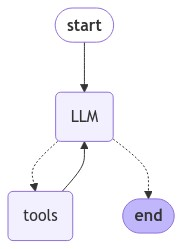

In [22]:
agent = workflow.compile()

display(Image(agent.get_graph().draw_mermaid_png()))

As shown in the image, we start with the LLM. The LLM either calls the tools or ends based on the available information to it. If it calls any tool, the tool executes and send the result back to the LLM. And the LLM again decides to call the tool or end.

In [23]:
for chunk in agent.stream(
    {"messages": [("user", "Will it rain in Bengaluru today?")]},
    stream_mode="values",
):

    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Will it rain in Bengaluru today?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_61d1)
 Call ID: call_61d1
  Args:
    query: Bengaluru
================================= Tool Message =================================
Name: get_weather

{"location": {"name": "Bengaluru", "region": "Karnataka", "country": "India", "lat": 12.98, "lon": 77.58, "tz_id": "Asia/Kolkata", "localtime_epoch": 1725726614, "localtime": "2024-09-07 22:00"}, "current": {"last_updated_epoch": 1725725700, "last_updated": "2024-09-07 21:45", "temp_c": 23.1, "temp_f": 73.6, "is_day": 0, "condition": {"text": "Partly cloudy", "icon": "//cdn.weatherapi.com/weather/64x64/night/116.png", "code": 1003}, "wind_mph": 11.9, "wind_kph": 19.1, "wind_degree": 260, "wind_dir": "W", "pressure_mb": 1015.0, "pressure_in": 29.97, "precip_mm": 0.0, "precip_in": 0.0, "humidity": 83, "cloud": 7

As I have asked about the weather, get_weather tool is called and it returned various weather related values. Based on those values, the LLM returned that it is unlikely to rain.

In this way, we can add different kinds of tools to the LLM so that we can get our queries answered even if LLM alone can’t answer. Thus LLM agents will be far more useful in many scenarios